In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# 1. Configurarea Datelor
data_dir = 'data'  # Directorul unde sunt stocate imaginile
img_size = 48
num_classes = 8  # Ex: 8 clase de emoții
batch_size = 64
epochs = 100

emotion_labels = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happy': 4,
    'neutral': 5,
    'sad': 6,
    'surprise': 7
}

# 2. Încărcarea și Preprocesarea Datelor
X = []
y = []

for emotion, label in emotion_labels.items():
    folder_path = os.path.join(data_dir, emotion)
    if os.path.exists(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_resized = cv2.resize(img_gray, (img_size, img_size))
                img_normalized = img_resized / 255.0
                X.append(np.expand_dims(img_normalized, axis=-1))
                y.append(label)

X = np.array(X, dtype='float32')
y = np.array(y)

y_onehot = to_categorical(y, num_classes=num_classes)

# Împărțirea Datelor în Seturi de Antrenament și Validare
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

# 3. Augmentarea Datelor pentru Antrenament
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# 4. Definirea Modelului CNN
model = Sequential()

# Bloc 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloc 2
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloc 3
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.6))  # Dropout pentru a reduce overfitting-ul

model.add(Dense(num_classes, activation='softmax'))

# Compilarea Modelului
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 5. Callbacks pentru Antrenament
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    filepath='checkpoints/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 6. Antrenarea Modelului
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# 7. Evaluarea Modelului pe Setul de Test
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Acuratețe pe setul de test: {test_accuracy * 100:.2f}%")

# 8. Încărcarea Modelului cu Cele Mai Bune Performanțe
from tensorflow.keras.models import load_model
best_model = load_model('checkpoints/best_model.keras')
print("Cel mai bun model a fost încărcat.")


c:\Users\Andrei\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,552 (4.87 MB)

 Trainable params: 1,275,592 (4.87 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/100


c:\Users\Andrei\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1497 - loss: 3.1630
Epoch 1: val_accuracy improved from -inf to 0.17628, saving model to checkpoints/best_model.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.1497 - loss: 3.1624 - val_accuracy: 0.1763 - val_loss: 2.4708 - learning_rate: 0.0010
Epoch 2/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1829 - loss: 2.4851
Epoch 2: val_accuracy did not improve from 0.17628
364/364 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1829 - loss: 2.4848 - val_accuracy: 0.1589 - val_loss: 2.3005 - learning_rate: 0.0010
Epoch 3/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2233 - loss: 2.1983
Epoch 3: val_accuracy improved from 0.17628 to 0.26442, saving model to checkpoints/best_model.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.2233 - loss: 2.1983 - val_accuracy: 0.2644 - val_loss: 2.0655 - learning_rate: 0.0010
Epoch 4/100
363/364 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.245

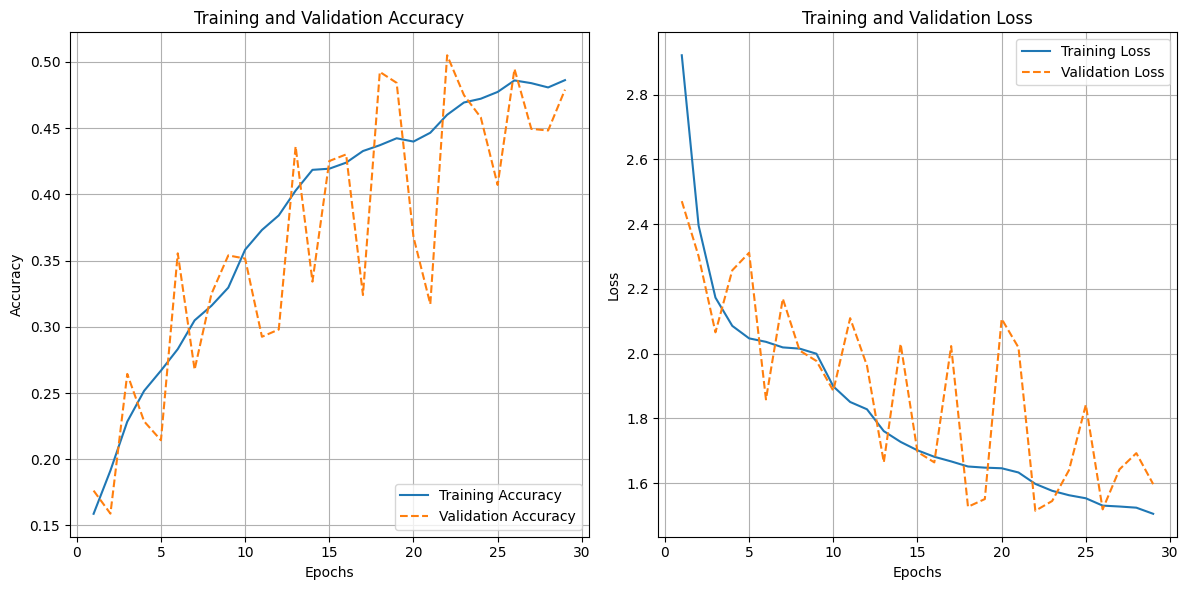

182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 1000x800 with 0 Axes>

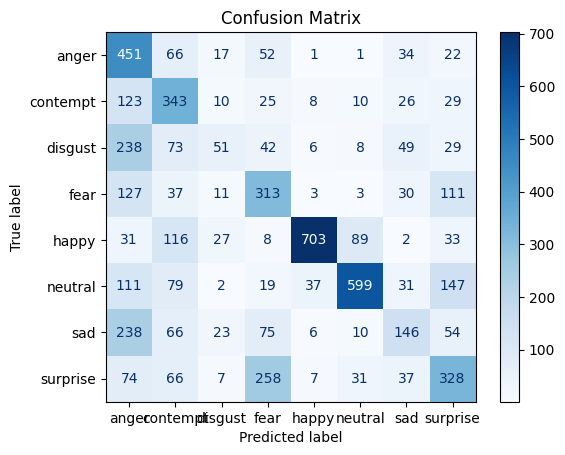

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Accesarea istoricului de antrenament
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# 2. Plot pentru acuratețe
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, linestyle='--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# 3. Plot pentru pierdere (loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, linestyle='--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Matricea de confuzie
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertim probabilitățile în clase
y_true = np.argmax(y_val, axis=1)  # Convertim one-hot la clase

cm = confusion_matrix(y_true, y_pred_classes)
labels = list(emotion_labels.keys())  # Etichetele claselor

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
